In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd  # <-- Новый импорт

# Чтение данных с помощью pandas (более устойчиво к проблемам с кодировкой)
df = pd.read_csv('load_stroke_compression.csv', delimiter=',', header=None)

# Преобразуем в numpy массивы
stroke = df[0].values  # перемещение [мм]
load = df[1].values    # сила [Н]

print("Данные успешно загружены.")
print(f"Количество точек: {len(stroke)}")

Данные успешно загружены.
Количество точек: 549


In [35]:
class CompressionDataSegmenter:
    def __init__(self, stroke, load):
        """
        Автоматическое разделение диаграммы сжатия на 3 участка:
        1. Выборка зазоров
        2. Упругая деформация
        3. Пластическое течение
        
        Параметры:
        ----------
        stroke : array-like
            Перемещение (мм)
        load : array-like
            Сила (Н)
        """
        self.stroke = np.asarray(stroke)
        self.load = np.asarray(load)
        self._find_segments()

    def _find_segments(self):
        """
        Определяет границы трёх участков.
        """
        # === 1. Граница выборки зазоров ===
        # Ищем первую точку, где сила превышает 1000 Н
        force_threshold = 1000
        idx_significant_force = np.where(self.load > force_threshold)[0]
        if len(idx_significant_force) > 0:
            i1 = idx_significant_force[0]
        else:
            i1 = min(3, len(self.load) - 2)

        # === 2. Граница упругой области ===
        # Ищем максимально длинный линейный участок, начиная с i1
        start_elastic = i1
        best_end = start_elastic + 1
        r2_threshold = 0.99  # Порог для R²
        
        for end in range(start_elastic + 2, len(self.load)):
            X = self.stroke[start_elastic:end].reshape(-1, 1)
            y = self.load[start_elastic:end]
            model = LinearRegression().fit(X, y)
            r2 = r2_score(y, model.predict(X))
            
            # Если R² всё ещё выше порога, продолжаем расширять участок
            if r2 >= r2_threshold:
                best_end = end
            else:
                # Как только R² упало ниже порога, останавливаемся
                break

        i2 = best_end

        # === 3. Пластическое течение ===
        i3 = len(self.stroke)

        # Сохраняем границы
        self.segments = {
            'Выборка зазоров': (0, i1),
            'Упругая деформация': (i1, i2),
            'Пластическое течение': (i2, i3)
        }

    def plot_segments(self, ax=None):
        """
        Строит график с цветовой разметкой трёх участков и вертикальными линиями-границами.
        """
        import matplotlib.pyplot as plt
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 7))

        colors = ['orange', 'green', 'red']
        names = ['Выборка зазоров', 'Упругая деформация', 'Пластическое течение']

        # Построение графика по участкам
        for (name, (start, end)), color in zip(self.segments.items(), colors):
            if end > start:
                ax.plot(
                    self.stroke[start:end],
                    self.load[start:end],
                    color=color,
                    linewidth=2.5,
                    label=f'{name} (точки {start}–{end-1})'
                )

        # Добавление вертикальных пунктирных линий на границах участков
        if len(self.stroke) > 0:
            # Граница между выборкой зазоров и упругой областью
            if self.segments['Выборка зазоров'][1] < len(self.stroke):
                x_gap_end = self.stroke[self.segments['Выборка зазоров'][1]]
                ax.axvline(x=x_gap_end, color='orange', linestyle='--', linewidth=1.5, label='Граница зазоров')
            
            # Граница между упругой областью и пластическим течением
            if self.segments['Упругая деформация'][1] < len(self.stroke):
                x_elastic_end = self.stroke[self.segments['Упругая деформация'][1]]
                ax.axvline(x=x_elastic_end, color='green', linestyle='--', linewidth=1.5, label='Граница упругости')

        # Настройка графика
        ax.set_xlabel('Перемещение, мм', fontsize=12)
        ax.set_ylabel('Сила, Н', fontsize=12)
        ax.set_title('Разделение диаграммы сжатия на участки', fontsize=14)
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Вывод информации о границах в консоль
        print(f"Границы участков:")
        print(f"  Выборка зазоров: от точки {self.segments['Выборка зазоров'][0]} до {self.segments['Выборка зазоров'][1]-1}")
        print(f"  Упругая деформация: от точки {self.segments['Упругая деформация'][0]} до {self.segments['Упругая деформация'][1]-1}")
        print(f"  Пластическое течение: от точки {self.segments['Пластическое течение'][0]} до {self.segments['Пластическое течение'][1]-1}")

        return ax

Границы участков:
  Выборка зазоров: от точки 0 до 2
  Упругая деформация: от точки 3 до 18
  Пластическое течение: от точки 19 до 548


<Figure size 1400x800 with 0 Axes>

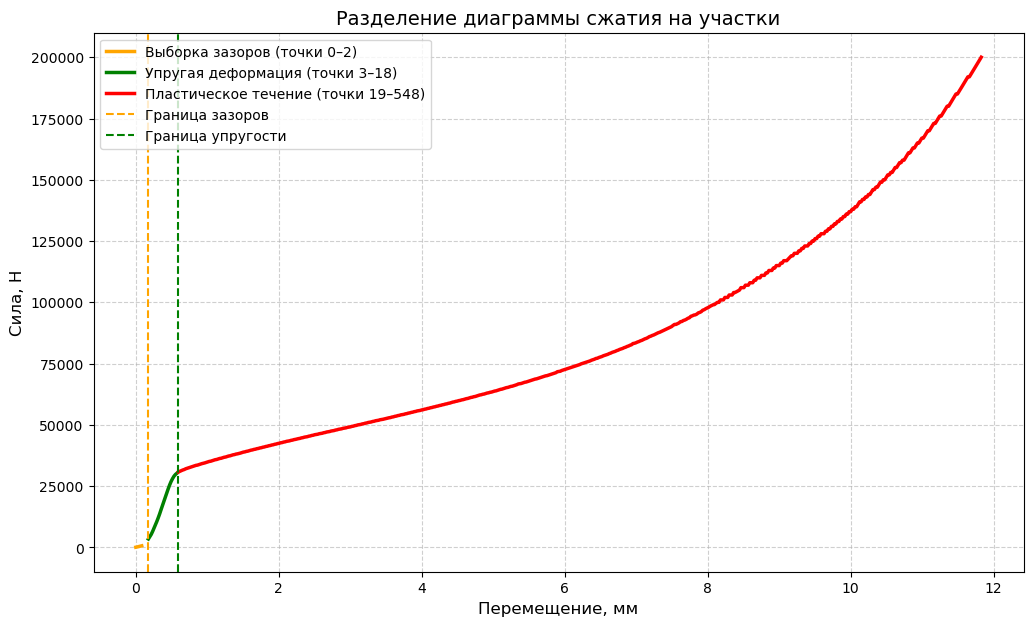

In [36]:
# Создание экземпляра класса
segmenter = CompressionDataSegmenter(stroke, load)

# Построение графика
plt.figure(figsize=(14, 8))
ax = segmenter.plot_segments()
plt.show()